
------------------------------ RESULTADO FINAL (OOT) - XGBoost Otimizado ------------------------------
>> Performance no Teste Out-of-Time: AUC = 0.6424, KS = 0.1937
---------------------------------------------------------------------------------

CALIBRAÇÃO DO MODELO ORIGINAL (UNCALIBRATED)
Dev Set (Original/Uncalibrated) Calibration Metrics:
  Brier Score: 0.0717
  Expected Calibration Error: 0.0306
  Log Loss: 0.2582

OOT Set (Original/Uncalibrated) Calibration Metrics:
  Brier Score: 0.0934
  Expected Calibration Error: 0.0235
  Log Loss: 0.3299

Plotando curva de calibração do modelo original...


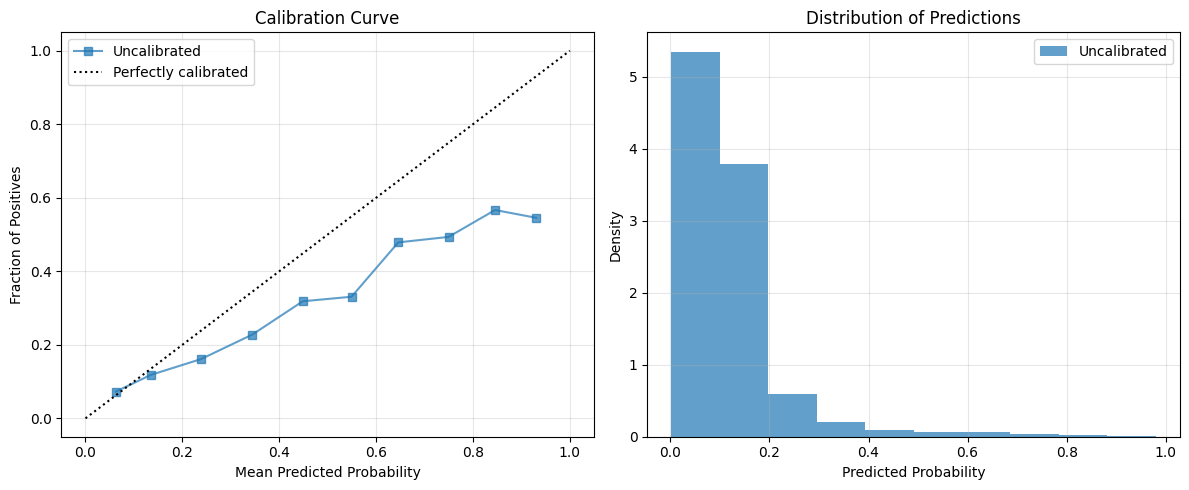


STARTING PROBABILITY CALIBRATION

--- Testing PLATT calibration ---

PLATT Calibration Results:
Dev Set (platt) Calibration Metrics:
  Brier Score: 0.0687
  Expected Calibration Error: 0.0135
  Log Loss: 0.2509

OOT Set (platt) Calibration Metrics:
  Brier Score: 0.1069
  Expected Calibration Error: 0.0526
  Log Loss: 0.3876

Performance: AUC = 0.6424, KS = 0.1937

--- Testing ISOTONIC calibration ---

ISOTONIC Calibration Results:
Dev Set (isotonic) Calibration Metrics:
  Brier Score: 0.0678
  Expected Calibration Error: 0.0000
  Log Loss: 0.2443

OOT Set (isotonic) Calibration Metrics:
  Brier Score: 0.1079
  Expected Calibration Error: 0.0671
  Log Loss: 0.4368

Performance: AUC = 0.6424, KS = 0.1906

--- Testing BETA calibration ---

BETA Calibration Results:
Dev Set (beta) Calibration Metrics:
  Brier Score: 0.2784
  Expected Calibration Error: 0.4377
  Log Loss: 0.7761

OOT Set (beta) Calibration Metrics:
  Brier Score: 0.3638
  Expected Calibration Error: 0.4902
  Log Loss: 1.1

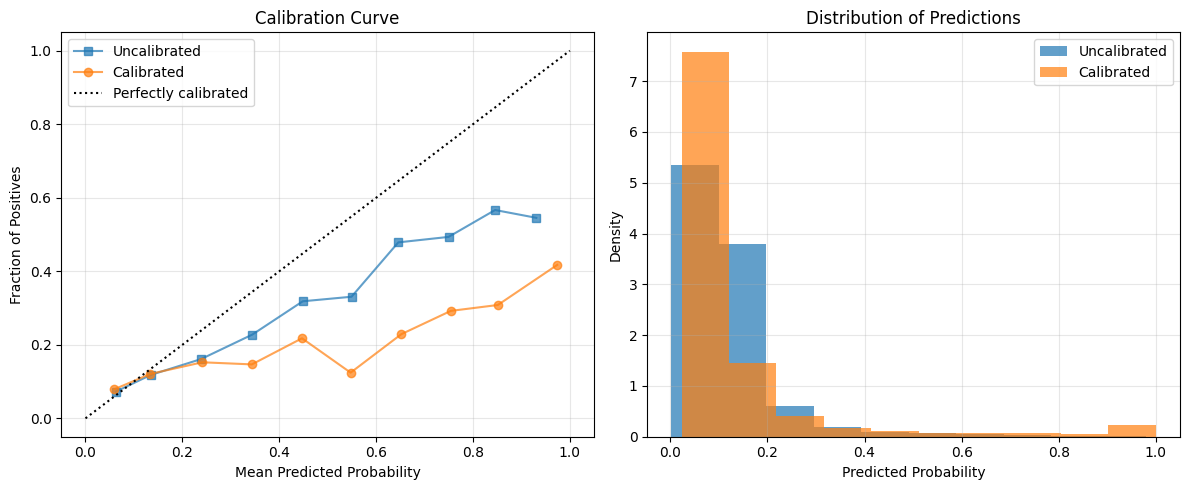

In [4]:
import pandas as pd
import numpy as np
from typing import Dict, Tuple, List

from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from james_stein_custom import _JamesSteinEncoder
import xgboost as xgb

import optuna
import shap

import category_encoders as ce

from sklearn.metrics import roc_auc_score
from scipy import stats
import matplotlib.pyplot as plt

# Add calibration imports
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, log_loss
import pickle

def calcular_ks_scipy(y_true: np.ndarray, y_pred_proba: np.ndarray) -> float:
    prob_bads = y_pred_proba[y_true == 1]
    prob_goods = y_pred_proba[y_true == 0]
    if len(prob_bads) == 0 or len(prob_goods) == 0: return 0.0
    ks_statistic, p_value = stats.ks_2samp(prob_bads, prob_goods)
    return ks_statistic

def weighted_logloss_obj(y_pred_raw: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    y_true = dtrain.get_label()
    costs = dtrain.get_weight() 
    p = 1.0 / (1.0 + np.exp(-y_pred_raw))
    grad = costs * (p - y_true)
    hess = costs * p * (1.0 - p)
    return grad, hess

def ks_auc_feval(y_pred_raw: np.ndarray, dtrain: xgb.DMatrix) -> List[Tuple[str, float]]:
    y_true = dtrain.get_label()
    p = 1.0 / (1.0 + np.exp(-y_pred_raw))
    auc = roc_auc_score(y_true, p)
    ks = calcular_ks_scipy(y_true, p)
    return [('auc', auc), ('ks', ks)]

# CALIBRATION FUNCTIONS
def platt_scaling(y_true, y_pred_proba):
    """Calibrate probabilities using Platt scaling (logistic regression)"""
    y_pred_proba_reshaped = y_pred_proba.reshape(-1, 1)
    calibrator = LogisticRegression()
    calibrator.fit(y_pred_proba_reshaped, y_true)
    calibrated_proba = calibrator.predict_proba(y_pred_proba_reshaped)[:, 1]
    return calibrated_proba, calibrator

def isotonic_calibration(y_true, y_pred_proba):
    """Calibrate probabilities using isotonic regression"""
    calibrator = IsotonicRegression(out_of_bounds='clip')
    calibrated_proba = calibrator.fit_transform(y_pred_proba, y_true)
    return calibrated_proba, calibrator

def beta_calibration(y_true, y_pred_proba):
    """Beta calibration using method of moments"""
    mean_pred = np.mean(y_pred_proba)
    var_pred = np.var(y_pred_proba)
    
    if var_pred == 0:
        return y_pred_proba, None
    
    # Method of moments for beta distribution
    a = mean_pred * (mean_pred * (1 - mean_pred) / var_pred - 1)
    b = (1 - mean_pred) * (mean_pred * (1 - mean_pred) / var_pred - 1)
    
    if a <= 0 or b <= 0:
        # Fallback to Platt scaling
        return platt_scaling(y_true, y_pred_proba)
    
    # Transform predictions using beta CDF
    from scipy.stats import beta
    calibrated_proba = beta.cdf(y_pred_proba, a, b)
    
    return calibrated_proba, (a, b)

def evaluate_calibration(y_true, y_pred_proba, method_name=""):
    """Evaluate calibration using multiple metrics"""
    try:
        # Brier Score (lower is better)
        brier = brier_score_loss(y_true, y_pred_proba)
        
        # Expected Calibration Error (ECE)
        def expected_calibration_error(y_true, y_prob, n_bins=10):
            bin_boundaries = np.linspace(0, 1, n_bins + 1)
            bin_lowers = bin_boundaries[:-1]
            bin_uppers = bin_boundaries[1:]
            
            ece = 0
            for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
                in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
                prop_in_bin = in_bin.mean()
                
                if prop_in_bin > 0:
                    accuracy_in_bin = y_true[in_bin].mean()
                    avg_confidence_in_bin = y_prob[in_bin].mean()
                    ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            
            return ece
        
        ece = expected_calibration_error(y_true, y_pred_proba)
        
        # Log loss (lower is better)
        ll = log_loss(y_true, y_pred_proba)
        
        print(f"{method_name} Calibration Metrics:")
        print(f"  Brier Score: {brier:.4f}")
        print(f"  Expected Calibration Error: {ece:.4f}")
        print(f"  Log Loss: {ll:.4f}")
        print()
        
        return {"brier": brier, "ece": ece, "log_loss": ll}
    except Exception as e:
        print(f"Error evaluating calibration for {method_name}: {e}")
        return None

def plot_calibration_curve(y_true, y_pred_proba, y_pred_calibrated=None, n_bins=10):
    """Plot calibration curve"""
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Reliability diagram
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_pred_proba, n_bins=n_bins
        )
        
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Uncalibrated", alpha=0.7)
        
        if y_pred_calibrated is not None:
            fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
                y_true, y_pred_calibrated, n_bins=n_bins
            )
            ax1.plot(mean_predicted_value_cal, fraction_of_positives_cal, "o-", label="Calibrated", alpha=0.7)
        
        ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        ax1.set_xlabel("Mean Predicted Probability")
        ax1.set_ylabel("Fraction of Positives")
        ax1.set_title("Calibration Curve")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Histogram of predictions
        ax2.hist(y_pred_proba, bins=n_bins, alpha=0.7, label="Uncalibrated", density=True)
        if y_pred_calibrated is not None:
            ax2.hist(y_pred_calibrated, bins=n_bins, alpha=0.7, label="Calibrated", density=True)
        ax2.set_xlabel("Predicted Probability")
        ax2.set_ylabel("Density")
        ax2.set_title("Distribution of Predictions")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting calibration curve: {e}")

# YOUR ORIGINAL CODE STARTS HERE
try:
    treino_df = pd.read_csv("../data/dev/train.csv", index_col=0)
    validacao_df = pd.read_csv("../data/dev/val.csv", index_col=0)
    teste_oot_df = pd.read_csv("../data/dev/test.csv", index_col=0)

    dev_df = pd.concat([treino_df, validacao_df], ignore_index=True)
    
    TARGET = 'target'
    COST_FN_COL = 'custo_fn'
    COST_FP_COL = 'custo_fp'
    
    FEATURES = [col for col in dev_df.columns if col not in [
        TARGET, 'data_originacao', 'id_contrato', COST_FN_COL, COST_FP_COL
    ]]

    X_dev = dev_df[FEATURES]
    y_dev = dev_df[TARGET]
    
    costs_dev = np.where(y_dev == 1, dev_df[COST_FN_COL], dev_df[COST_FP_COL])

    X_oot = teste_oot_df[FEATURES]
    y_oot = teste_oot_df[TARGET]
    
except FileNotFoundError as e:
    print(f"Problema com os dados: {e}")
    exit()

js_cols = ['estado', 'id_varejo']
ohe_cols = ['tipo_cliente']
target_enc_cols = [col for col in FEATURES if col.endswith('_bin')]

preprocessor = ColumnTransformer(
    transformers=[
        ('james_stein', _JamesSteinEncoder(min_samples = 200), js_cols),
        ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=5), ohe_cols),
        ('target_encoder', ce.TargetEncoder(), target_enc_cols)
    ],
    remainder='passthrough'
)

def objective(trial: optuna.Trial) -> float:
    params = {
        'objective': 'binary:logistic',
        'booster': 'gbtree', 'n_jobs': -1,
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 100, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    fold_auc_scores = [] 

    for train_index, val_index in tscv.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        costs_train_fold = costs_dev[train_index]
        
        X_train_processed = preprocessor.fit_transform(X_train_fold, y_train_fold)
        X_val_processed = preprocessor.transform(X_val_fold)
        
        dtrain = xgb.DMatrix(X_train_processed, label=y_train_fold, weight=costs_train_fold)
        dval = xgb.DMatrix(X_val_processed, label=y_val_fold)
        
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,
            evals=[(dval, 'validation')],
            obj=weighted_logloss_obj,
            custom_metric=ks_auc_feval,
            callbacks=[xgb.callback.EarlyStopping(rounds=50, metric_name='auc', maximize=True)],
            verbose_eval=False
        )
        fold_auc_scores.append(model.best_score)

    return np.mean(fold_auc_scores)

# Use your champion parameters directly
best_params = {
    'eta': 0.02981817705643833, 
    'max_depth': 5, 
    'subsample': 0.6697958153560689, 
    'colsample_bytree': 0.6787432374671623, 
    'min_child_weight': 2.2344895626604364, 
    'lambda': 0.009605919635255544, 
    'alpha': 0.0032243808706101523,
    'objective': 'binary:logistic', 
    'booster': 'gbtree', 
    'n_jobs': -1
}

# Train final model
X_dev_processed = preprocessor.fit_transform(X_dev, y_dev)
X_oot_processed = preprocessor.transform(X_oot)

dtrain_final = xgb.DMatrix(X_dev_processed, label=y_dev, weight=costs_dev)
doot = xgb.DMatrix(X_oot_processed, label=y_oot)

final_model = xgb.train(
    params=best_params,
    dtrain=dtrain_final,
    num_boost_round=500, 
    obj=weighted_logloss_obj,
    verbose_eval=100
)

# Get uncalibrated predictions
y_oot_pred_proba_tuned = final_model.predict(doot)

# Calculate original metrics
auc_oot_tuned = roc_auc_score(y_oot, y_oot_pred_proba_tuned)
ks_oot_tuned = calcular_ks_scipy(y_oot.values, y_oot_pred_proba_tuned)

print("\n" + "---" * 10 + " RESULTADO FINAL (OOT) - XGBoost Otimizado " + "---" * 10)
print(f">> Performance no Teste Out-of-Time: AUC = {auc_oot_tuned:.4f}, KS = {ks_oot_tuned:.4f}")
print("---" * 27)

# ===================================================================
# AVALIAR CALIBRAÇÃO DO MODELO ORIGINAL (ANTES DA CALIBRAÇÃO)
# ===================================================================
print("\n" + "="*60)
print("CALIBRAÇÃO DO MODELO ORIGINAL (UNCALIBRATED)")
print("="*60)

# Avaliar calibração no conjunto de desenvolvimento
y_dev_pred_uncalibrated = final_model.predict(xgb.DMatrix(X_dev_processed))
dev_calibration_metrics = evaluate_calibration(y_dev, y_dev_pred_uncalibrated, "Dev Set (Original/Uncalibrated)")

# Avaliar calibração no conjunto OOT
oot_calibration_metrics = evaluate_calibration(y_oot, y_oot_pred_proba_tuned, "OOT Set (Original/Uncalibrated)")

# Plot reliability diagram for original model
print("Plotando curva de calibração do modelo original...")
plot_calibration_curve(y_oot, y_oot_pred_proba_tuned)

# NOW START CALIBRATION
print("\n" + "="*60)
print("STARTING PROBABILITY CALIBRATION")
print("="*60)

# Test different calibration methods
methods = ['platt', 'isotonic', 'beta']
calibration_results = {}

for method in methods:
    print(f"\n--- Testing {method.upper()} calibration ---")
    try:
        # Calibrate using development set
        if method == 'platt':
            y_dev_pred_calibrated, calibrator = platt_scaling(y_dev, y_dev_pred_uncalibrated)
            # Apply to OOT
            y_oot_pred_calibrated = calibrator.predict_proba(y_oot_pred_proba_tuned.reshape(-1, 1))[:, 1]
            
        elif method == 'isotonic':
            y_dev_pred_calibrated, calibrator = isotonic_calibration(y_dev, y_dev_pred_uncalibrated)
            # Apply to OOT
            y_oot_pred_calibrated = calibrator.transform(y_oot_pred_proba_tuned)
            
        elif method == 'beta':
            y_dev_pred_calibrated, calibrator = beta_calibration(y_dev, y_dev_pred_uncalibrated)
            if calibrator is not None:
                from scipy.stats import beta
                a, b = calibrator
                y_oot_pred_calibrated = beta.cdf(y_oot_pred_proba_tuned, a, b)
            else:
                y_oot_pred_calibrated = y_oot_pred_proba_tuned
        
        # Evaluate calibration quality
        print(f"\n{method.upper()} Calibration Results:")
        evaluate_calibration(y_dev, y_dev_pred_calibrated, f"Dev Set ({method})")
        evaluate_calibration(y_oot, y_oot_pred_calibrated, f"OOT Set ({method})")
        
        # Calculate performance metrics
        calibrated_auc = roc_auc_score(y_oot, y_oot_pred_calibrated)
        calibrated_ks = calcular_ks_scipy(y_oot.values, y_oot_pred_calibrated)
        
        calibration_results[method] = {
            'probabilities': y_oot_pred_calibrated,
            'calibrator': calibrator,
            'auc': calibrated_auc,
            'ks': calibrated_ks
        }
        
        print(f"Performance: AUC = {calibrated_auc:.4f}, KS = {calibrated_ks:.4f}")
        
    except Exception as e:
        print(f"Error with {method} calibration: {e}")

# Summary and comparison
print("\n" + "="*60)
print("COMPARAÇÃO FINAL: ORIGINAL vs CALIBRADO")
print("="*60)

print(f"MODELO ORIGINAL (Uncalibrated):")
print(f"  Performance: AUC = {auc_oot_tuned:.4f}, KS = {ks_oot_tuned:.4f}")
if oot_calibration_metrics:
    print(f"  Calibração (OOT): Brier = {oot_calibration_metrics['brier']:.4f}, ECE = {oot_calibration_metrics['ece']:.4f}, Log Loss = {oot_calibration_metrics['log_loss']:.4f}")
print()

best_method = None
best_score = -1

for method, results in calibration_results.items():
    print(f"{method.upper()} CALIBRADO:")
    print(f"  Performance: AUC = {results['auc']:.4f}, KS = {results['ks']:.4f}")
    print()
    # You can change this criteria - here we're optimizing for AUC
    if results['auc'] > best_score:
        best_score = results['auc']
        best_method = method

if best_method and len(calibration_results) > 0:
    print(f"Melhor método de calibração: {best_method.upper()}")
    final_calibrated_proba = calibration_results[best_method]['probabilities']
    final_calibrator = calibration_results[best_method]['calibrator']
    
    # Plot comparison between original and best calibrated
    print(f"\nPlotando comparação: Original vs {best_method.upper()} calibrado...")
    plot_calibration_curve(y_oot, y_oot_pred_proba_tuned, final_calibrated_proba)